# k-Means Clustering

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from fast_pagerank import pagerank
from fast_pagerank import pagerank_power
from scipy import sparse
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

import utils

In [5]:
# Load data
df_data = pd.read_csv('../data/ice-cat-office-products.csv.gz', dtype=str, index_col=0)

# Filter out small product categories
# top_categories = utils.find_top_n_categories(df_data, top_n=3)
top_categories = [
     'Folders',                         # N=645
     'Self-Adhesive Labels',            # N=324
     'Multimedia Carts & Stands',       # N=317
#     'Calculators',                     # N=305
#     'Writing Notebooks'                # N=300
     'Ring Binders',                    # N=298
     'Printer Cabinets & Stands',       # N=252
#     'Whiteboards',                     # N=232
#     'Fax Machines',                    # N=210
#     'File Storage Boxes'               # N=192
]
df_data = df_data[df_data.category_name.isin(top_categories)]

# Sort by category for later visualisation
df_data.sort_values('category_name', inplace=True)

product_features = utils.get_product_feature_columns_for_training(df_data)

df_play_data = df_data[['category_name'] + product_features].copy()

fill_ratios = utils.get_fill_ratios_for_product_features_per_category(df_play_data)
valid_cats_per_feat = utils.get_valid_categories_per_product_feature(fill_ratios)

In [6]:
X_raw = utils.preprocess_dataframe(df_play_data, valid_cats_per_feat)
X_raw.shape

(1836, 462)

In [7]:
# Reduce to number of dimensions so the remaining dimensions
# explain at least 90 percent of the variance.
svd = PCA(n_components=0.9, random_state=42)
X_pca = svd.fit_transform(X_raw)
X_pca.shape

(1836, 33)

In [8]:
scores = []
k_range = range(2, 50)
for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_pca)
    
    clustering_labels = kmeans.labels_
    
    scores.append({
        'k': k,
        
        # Inertia: sum of squared distances of samples to their closest cluster center.
        'inertia': kmeans.inertia_,
        
        'davies_bouldin': davies_bouldin_score(X_pca, clustering_labels),
        'calinski_harabasz': calinski_harabasz_score(X_pca, clustering_labels),
        'silhouette': silhouette_score(X_pca, clustering_labels),
    })

  0%|          | 0/48 [00:00<?, ?it/s]

In [9]:
df_clustering_scores = pd.DataFrame(scores).set_index('k')

<AxesSubplot:xlabel='k'>

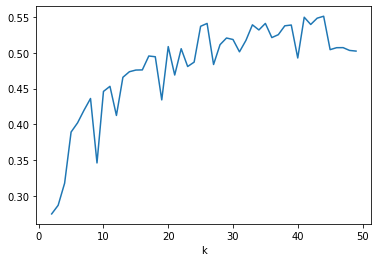

In [15]:
df_clustering_scores["silhouette"].plot()

<AxesSubplot:xlabel='k'>

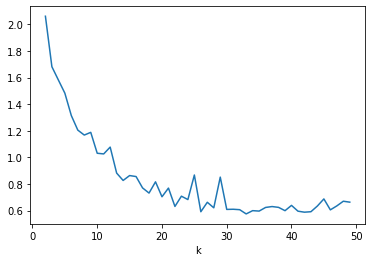

In [16]:
df_clustering_scores["davies_bouldin"].plot()

<AxesSubplot:xlabel='k'>

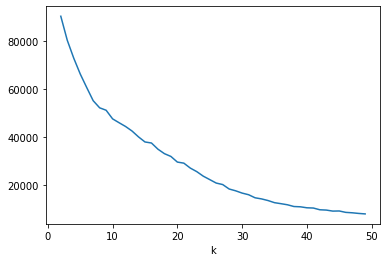

In [17]:
df_clustering_scores["inertia"].plot()

<AxesSubplot:xlabel='k'>

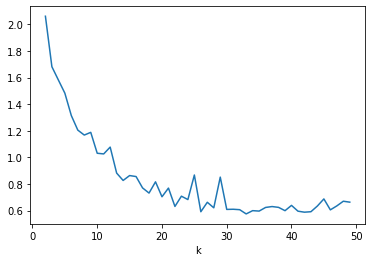

In [18]:
df_clustering_scores['davies_bouldin'].plot()

In [19]:
kmeans = KMeans(n_clusters=30, init="k-means++", random_state=42)
kmeans.fit(X_pca)

KMeans(n_clusters=30, random_state=42)

In [20]:
df_cleaned_data, features_by_type = utils.prepare_for_preprocessing(df_data)

# Add extra columns
df_cleaned_data['title'] = df_data['title']

# Assign clusters to the original data
df_cleaned_data['cluster'] = kmeans.labels_
df_cleaned_data['cluster'] = df_cleaned_data['cluster'].astype(str)

In [21]:
# Count number of rows where clustering and known ground truths differ/agree
utils.group_clusters_per_category(df_cleaned_data)

,cluster,category_name,n_rows
0,0,Ring Binders,63
1,1,Folders,81
2,10,Multimedia Carts & Stands,4
3,11,Multimedia Carts & Stands,8
4,11,Printer Cabinets & Stands,1
6,12,Printer Cabinets & Stands,39
5,12,Multimedia Carts & Stands,11
7,13,Multimedia Carts & Stands,1
8,14,Self-Adhesive Labels,51
9,15,Printer Cabinets & Stands,15


In [22]:
# Combine clusters that agree with the ground truths (given product categories)
df_cleaned_data = utils.combined_similar_clusters(df_cleaned_data)

# Count number of rows where clustering and known ground truths differ/agree
utils.group_clusters_per_category(df_cleaned_data, attr_name='pred_category')

,pred_category,category_name,n_rows
0,Folders,Folders,645
1,Multimedia Carts & Stands,Multimedia Carts & Stands,306
2,Multimedia Carts & Stands,Printer Cabinets & Stands,7
4,Printer Cabinets & Stands,Printer Cabinets & Stands,245
3,Printer Cabinets & Stands,Multimedia Carts & Stands,11
5,Ring Binders,Ring Binders,298
6,Self-Adhesive Labels,Self-Adhesive Labels,324
